<a target="_blank" href="https://colab.research.google.com/github/taobrienlbl/advanced_earth_science_data_analysis/blob/spring_2023_iub/lessons/04_digging_further_into_data_wrangling/04_estimating_building_height.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This exercise aims to build on your knowledge of the big-four data science libraries to use Kestrel atmospheric measurement devices to estimate the height difference between the ground floor and sixth floor of the Geology building.

# Background

Air pressure monotonically decreases with height in the atmosphere.  This is simply due to the fact that *air pressure is a measure of the weight of everything above*.  So higher up in the atmosphere there is less atmosphere (weight) above, and pressure decreases.

One of the basic principles of fluid dynamics is that a *pressure gradient*--a change in pressure over some distance--exerts a net force on the fluid that, in the absence of other forces, would cause the fluid to move.  So why then does the atmosphere not flow away to space in response to this pressure gradient?

To a very good approximation, the atmosphere is in *hydrostatic balance*, meaning that the vertical pressure gradient is balanced by the force of gravity on the air; gravity effectively negates the pressure gradient force.  This leads to one of the most essential equations in atmospheric science:

$$ \frac{\partial p}{\partial z} = -\rho g$$

where $p$ is the atmospheric pressure, $z$ is height away from the surface, $\rho$ is air density, and $g$ is the gravitational acceleration (we'll use $g \approx 9.806~\text{m s}^{-2}$ here).

If we combine this with the ideal gas law (written in a form that is convenient for atmospheric gasses, where $R_d \approx 287~\text{J kg}^{-1}\text{K}^{-1}$ represents a constant for air with the composition of Earth's atmosphere), we get a differential equation for pressure.

$$\text{Ideal gas law: }~p = \rho R_d T \to $$

$$ \frac{\partial p}{\partial z} = - \frac{p g}{R_d T} $$

We can approximate the derivatives in this equation using finite differences: $\partial p/\partial z \to \Delta p / \Delta z$, where $\Delta$ represents a (presumably small) difference between two pressure or height measurements.  We can then use this to solve for the change in height as a function of changes in pressure:

$$ \Delta z \approx - \frac{R_d T}{g} \frac{\Delta p}{p}$$

# Estimating height

Now imagine that we have a device that records pressure and temperature every second or so.  If you take that device and walk up a set of stairs, the recorded pressure will drop a bit for every second that you're ascending.  A pair of measurements taken at consecutive times can be used to estimate $\Delta p$, and the average of the two measurements can be used to estimate $p$ and $T$ over tha same time frame.  These values can be plugged in to the above formula to estimate the change in height between the two measurements.  The sum of all the changes in height then gives an estimate of the total change in height; we will have numerically integrated the differential equation that comes from combining hydrostatic balance and the ideal gas law.

## Instructions

1. form groups of two or three
1. acquaint yourself with the Kestrel measuring devices, and pair it to at least one of your phones using [Kestrel Link](https://kestrelinstruments.com/link-connectivity)
1. ensure that you can record measurements and export them to csv
1. take the kestrel device down to the ground floor of the Geology building; go to the loop
1. start recording
1. either walk up the stairwell, or take the elevator, up to the 7th floor (you can only access this floor from the western stairwell)
1. end recording
1. export the data to a CSV file and add it to your course git folder (into a folder for lesson 04)
1. estimate the difference in height between the two floors using the method above (*hint*: you should use `pandas`, and you should be able to make a new column for the calculation of $\Delta p$ and $\Delta z$ for each measurement, and then use the `.sum()` method)

*Delete this and insert some initial observations / thoughts for documenting the data analysis process using Markdown*

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# open weather measurement file
file_path = "WEATHER_-_2414786_Sep_15_2023_2_54_46_PM.csv"
weather_df = pd.read_csv(file_path, skiprows=[0, 1, 2, 4], header=0, usecols=range(0,16), parse_dates=[0])
weather_df.head()

C:\Users\CRH\AppData\Local\Temp\ipykernel_21084\1262473777.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  weather_df = pd.read_csv(file_path, skiprows=[0, 1, 2, 4], header=0, usecols=range(0,16), parse_dates=[0])


,FORMATTED DATE_TIME,Temperature,Wet Bulb Temp,Relative Humidity,Barometric Pressure,Altitude,Station Pressure,Wind Speed,Heat Index,Dew Point,Density Altitude,Crosswind,Headwind,Compass Magnetic Direction,Compass True Direction,Wind Chill
0,2023-09-15 14:52:22,71.2,59.7,51.2,29.30,572,29.30,0.0,70.3,52.3,1674,--,--,--,--,71.1
1,2023-09-15 14:52:25,71.3,59.7,51.2,29.30,572,29.30,0.0,70.5,52.4,1681,--,--,--,--,71.2
2,2023-09-15 14:52:28,71.3,59.7,51.4,29.30,569,29.30,0.0,70.5,52.4,1676,--,--,--,--,71.2
3,2023-09-15 14:52:31,71.3,59.7,51.4,29.31,567,29.31,0.0,70.5,52.4,1674,--,--,--,--,71.2
4,2023-09-15 14:52:34,71.2,59.5,51.2,29.31,567,29.31,0.0,70.3,52.2,1669,--,--,--,--,71.1


In [3]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49 entries, 0 to 48
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   FORMATTED DATE_TIME         49 non-null     datetime64[ns]
 1   Temperature                 49 non-null     float64       
 2   Wet Bulb Temp               49 non-null     float64       
 3   Relative Humidity           49 non-null     float64       
 4   Barometric Pressure         49 non-null     float64       
 5   Altitude                    49 non-null     int64         
 6   Station Pressure            49 non-null     float64       
 7   Wind Speed                  49 non-null     float64       
 8   Heat Index                  49 non-null     float64       
 9   Dew Point                   49 non-null     float64       
 10  Density Altitude            49 non-null     int64         
 11  Crosswind                   49 non-null     object        
 

In [4]:
# define constant parameters
T = 288.15  # standard atmospheric temprature (K)
Rd = 287  # gas constant (J/kg/K)
g = 9.806  # gravity (m/s/s)

In [5]:
# Convert units to metrics
weather_df['Temperature_K'] = 273.5 + ((weather_df['Temperature'] - 32.0) * (5.0/9.0))
weather_df['Pressure_Pa'] = weather_df['Station Pressure']/0.00029530

In [6]:
# calcualte the changes in station pressure
weather_df['p_diff'] = weather_df['Pressure_Pa'].diff()

# calcualte the average pressure between pairs
weather_df['p_avg'] = 0.5*(weather_df['Pressure_Pa'].iloc[1:] + weather_df['Pressure_Pa'].iloc[:-1])

# calcualte the changes in height
weather_df['h_diff'] = -(Rd/g)*(weather_df['p_diff']*weather_df['Temperature_K']/weather_df['p_avg'])

# calculate the height
weather_df['height'] = weather_df['h_diff'].cumsum()

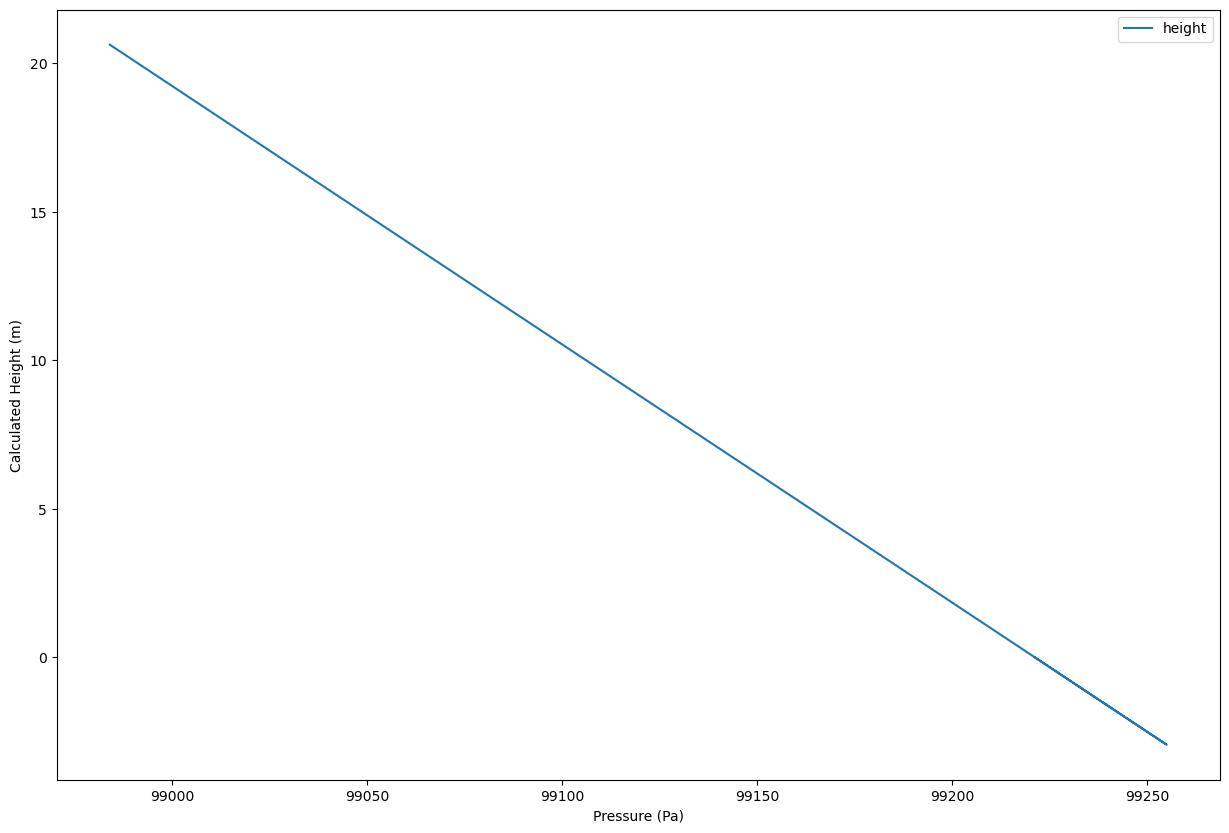

In [7]:
# plot the relationship between changes in pressure and height
fig, ax = plt.subplots(figsize=(15,10))
weather_df.plot(x='Pressure_Pa', y='height', ax = ax)
ax.set_xlabel("Pressure (Pa)")
ax.set_ylabel("Calculated Height (m)")
plt.show()

In [13]:
weather_df['height']

0           NaN
1      0.000000
2      0.000000
3     -2.949081
4     -2.949081
5     -2.949081
6     -0.000103
7     -0.000103
8     -0.000103
9      2.948215
10     2.948215
11     2.948215
12     2.948215
13     2.948215
14     2.948215
15     2.948215
16     5.893654
17     5.893654
18     5.893654
19     5.893654
20     5.893654
21     5.893654
22     8.838432
23     8.838432
24     8.838432
25     8.838432
26    11.784772
27    11.784772
28    11.784772
29    11.784772
30    11.784772
31    11.784772
32    11.784772
33    11.784772
34    14.732120
35    14.732120
36    14.732120
37    14.732120
38    17.681588
39    17.681588
40    17.681588
41    17.681588
42    17.681588
43    20.632064
44    20.632064
45    20.632064
46    20.632064
47    20.632064
48          NaN
Name: height, dtype: float64

In [16]:
N = len(weather_df['height'])
z_error = weather_df['height'].std()

print(f"The building height is {weather_df['height'].iloc[-2]:2.2f} m +/- {z_error:2.2f}")

The building height is 20.63 m +/- 7.21
